In [1]:
import numpy as np
from lib.utils import process_sensor_data
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = 'sc_sensor'
from lib.utils import gen_data_dict
import pickle
# dataset_name = "crossroad"
# dataset_name = "train_station"
dataset_name = "maze"
if dataset_name != "maze":
    df_dict = process_sensor_data(parent_dir, df_dict)  # only process sensor 2
    data_dict = gen_data_dict(df_dict)
    # process data dict to get the upstream and downstream data
    from lib.utils import seperate_up_down
    data_dict = seperate_up_down(data_dict)

elif dataset_name == "maze":
    with open("./sc_sensor/maze/flow_data.pkl", "rb") as f:
        data_dict = pickle.load(f)

In [2]:
dataset_name

'maze'

In [3]:
from lib.utils import sliding_win
from dgl.data.utils import load_graphs

g_data = load_graphs('./graphs/graphs.bin')
if dataset_name == "crossroad":
    # file_path = 'graphs/graph_data_crossroad.pkl'
    # with open(file_path, 'rb') as file:
    #     g = pickle.load(file)
    g = g_data[0][0]

elif dataset_name == "train_station":
    # file_path = 'graphs/graph_data_trainstation.pkl'
    # with open(file_path, 'rb') as file:
    #     g = pickle.load(file)
    g = g_data[0][1]

elif dataset_name == "maze":
    # file_path = 'graphs/graph_data_maze.pkl'
    # with open(file_path, 'rb') as file:
    #     g = pickle.load(file)
    g = g_data[0][2]

In [4]:
# if dataset_name == "crossroad":
#     train_sc = ['sc_sensor/crossroad2']
#     test_sc = ['sc_sensor/crossroad2_2']
# 
# if dataset_name == "train_station":
#     train_sc = ['sc_sensor/train6']
#     test_sc = ['sc_sensor/train3']
# 
# if dataset_name == "maze":
#     train_sc = ['sc_sensor/maze2']
#     test_sc = ['sc_sensor/maze0', 'sc_sensor/maze5','sc_sensor/maze8', 'sc_sensor/maze9',
#                'sc_sensor/maze10', ]

chunk_size = 30
lags = 5
# '''Has to >= 2'''
pred_horizon = 7 # 3, 5
sc = "sc_sensor/maze20"
sc_name = sc.split("/")[-1]
# sc = "sc_sensor/train13"
# sc = "sc_sensor/crossroad2"
x_test, y_test = sliding_win(data_dict[sc], lags=lags, horizons=pred_horizon)
num_input_timesteps = x_test.shape[1] # number of input time steps
num_nodes = x_test.shape[2] # number of ancestor nodes, minus the down stream node

In [24]:
import torch
from src.Diffusion_Network4 import Diffusion_Model
# from Diffusion_Network4_Density import Diffusion_Model
from src.Diffusion_Network4_UQ import Diffusion_Model_UQ
from src.Diffusion_Network5 import Diffusion_Model_plus
# dataset_name = "maze"
# dataset_name = "train_station"
src, dst = g.edges()
# model = Diffusion_Model_UQ(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)

# model = Diffusion_Model_Density(num_edges=len(src), num_timesteps_input=num_input_timesteps, graph=g, horizons=pred_horizon, scalar=None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# mdl = "Diffusion"
mdl = "Diffusion_plus"
# mdl = "Diffusion_UQ"
if mdl == "Diffusion":
    # model = Diffusion_Model(num_edges=len(src), num_timesteps_input=x_test.shape[1], graph=g, horizons=pred_horizon, device=device, scalar=None)
    model = Diffusion_Model(num_edges=len(src), num_timesteps_input=x_test.shape[1], graph=g, horizons=pred_horizon, device=device, scalar=None)
elif mdl == "Diffusion_UQ":
    model = Diffusion_Model_UQ(num_edges=len(src), num_timesteps_input=x_test.shape[1], graph=g, horizons=pred_horizon, device=device, scalar=None)
elif mdl == "Diffusion_plus":
    model = Diffusion_Model_plus(num_edges=len(src), num_timesteps_input=x_test.shape[1], graph=g, horizons=pred_horizon, device=device, scalar=None)
    
# chunk_size = 30
# lags = 5
# '''Has to >= 2'''
# pred_horizon = 5 # 3, 5

# only offline trained on a specific scenario
if mdl == "Diffusion":
    # w/ speed
    # model.load_state_dict(torch.load(f'./checkpoint/diffusion/offline_diffusion_model_network4_{dataset_name}_lags{lags}_hor{pred_horizon}.pth'))
    model.load_state_dict(torch.load(f'./checkpoint/diffusion/offline_diffusion_model_network4_maze_lags{lags}_hor{pred_horizon}_{sc_name}.pth'))
    # w/o speed
    # model.load_state_dict(torch.load(f'./checkpoint/diffusion/offline_diffusion_model_network4_wo_{dataset_name}_lags{lags}_hor{pred_horizon}.pth'))
elif mdl == "Diffusion_UQ":
    model.load_state_dict(torch.load(f'./checkpoint/diffusion/offline_diffusion_uq4_{dataset_name}_lags{lags}_hor{pred_horizon}.pth'))
elif mdl == "Diffusion_plus":
    model.load_state_dict(torch.load(f'./checkpoint/diffusion/diffusion_model_network5_{dataset_name}_lags{lags}_hor{pred_horizon}.pth'))
    # model.load_state_dict(torch.load(f'./checkpoint/diffusion/offline_diffusion_model_network5_{dataset_name}_lags{lags}_hor{pred_horizon}.pth'))


In [25]:
with torch.no_grad():
    x_up = torch.FloatTensor(x_test[..., src].transpose(2, 0, 1)) # [num of src, batch_size, num_timesteps_input], num of src = num of dst = num of edges
    x_down = torch.FloatTensor(x_test[..., dst].transpose(2, 0, 1)) # [num of dst, batch_size, num_timesteps_input]
    x = torch.FloatTensor(x_test.transpose(2, 0, 1))
    y = torch.FloatTensor(y_test.transpose(2, 0, 1))
    g.ndata['feature'] = x # [node, batch_size, num_timesteps_input]
    g.ndata['label'] = y # [node, batch_size, pred_horizon]
    # v = model.velocity_model(x_up, x_down).numpy()
    model(g.ndata['feature'][src], g.ndata['feature'][dst]) # conduct the prediction
    # flow = torch.sum(x_up, dim=2).numpy()
    total_flow = torch.mean(torch.cat([x_up, x_down], dim=-1), dim=-1).numpy() # sum of flow from upstream and downstream
pred_flow = model.g.edata['message']  # the predicted flow
pred_speed = model.g.edata['v']
F = model.g.edata['F']
pred_alpha = model.g.edata['alpha']

In [26]:
F.shape

torch.Size([48, 349])

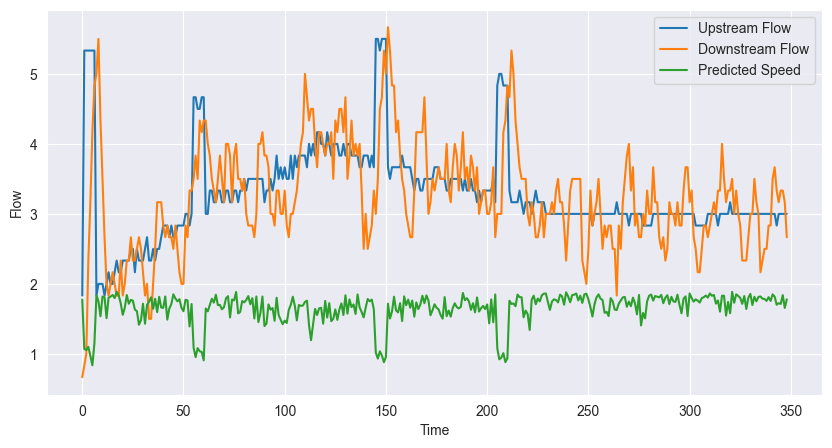

In [27]:
# plot x_up, x_down, and the predicted velocity
import matplotlib.pyplot as plt
src_idx = 0
dst_idx = 23
edge_id = np.where((src == src_idx) & (dst == dst_idx))[0]
time = np.arange(x_up.shape[1])
# figsize
plt.figure(figsize=(10, 5))
plt.plot(time, x_up[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Upstream Flow")
plt.plot(time, x_down[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Downstream Flow")
plt.plot(time, pred_speed[edge_id, :].numpy().squeeze(), label=f"Predicted Speed")
# plt.plot(time, F[edge_id, :].numpy().squeeze(), label=f"Predicted Diffusion")
plt.xlabel('Time')
plt.ylabel('Flow')
plt.legend()

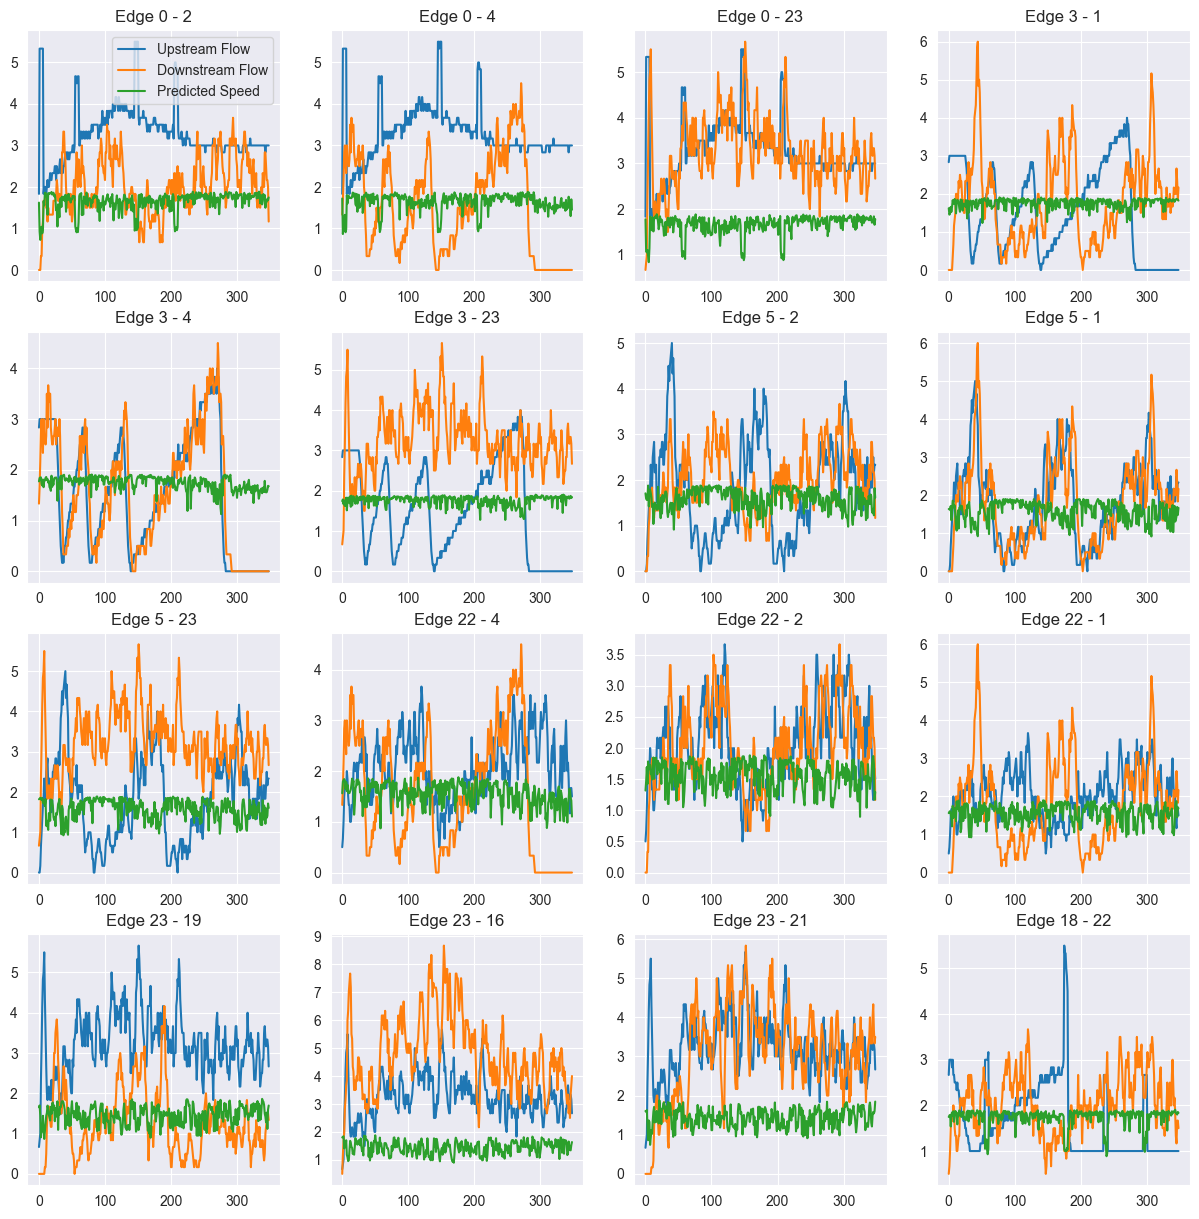

In [28]:
# plot x_up, x_down, and the predicted velocity for all edges
import matplotlib.pyplot as plt
subplot_length = 4
fig, axs = plt.subplots(subplot_length, subplot_length, figsize=(15, 15))
time = np.arange(x_up.shape[1])
for i in range(subplot_length**2):
    edge_id = i
    axs[i//subplot_length, i%subplot_length].plot(time, x_up[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Upstream Flow")
    axs[i//subplot_length, i%subplot_length].plot(time, x_down[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Downstream Flow")
    axs[i//subplot_length, i%subplot_length].plot(time, pred_speed[edge_id, :].numpy().squeeze(), label=f"Predicted Speed")
    axs[i//subplot_length, i%subplot_length].set_title(f"Edge {src[i]} - {dst[i]}")
    if i == 0:
        axs[i//subplot_length, i%subplot_length].legend()

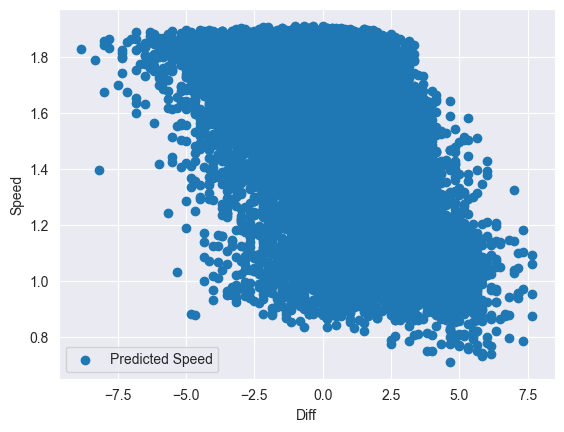

In [15]:
# plot tthe difference between upstream and downstream flow and the predicted velocity
import matplotlib.pyplot as plt
# time = np.arange(x_up.shape[1])
diff = x_up - x_down
# plt.plot(time, diff[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Upstream - Downstream Flow")
x = np.mean(diff[:, :, :].numpy(), axis=-1).squeeze()
plt.scatter(x, pred_speed[:, :].numpy().squeeze(), label=f"Predicted Speed")
plt.xlabel('Diff')
plt.ylabel('Speed')
plt.legend()

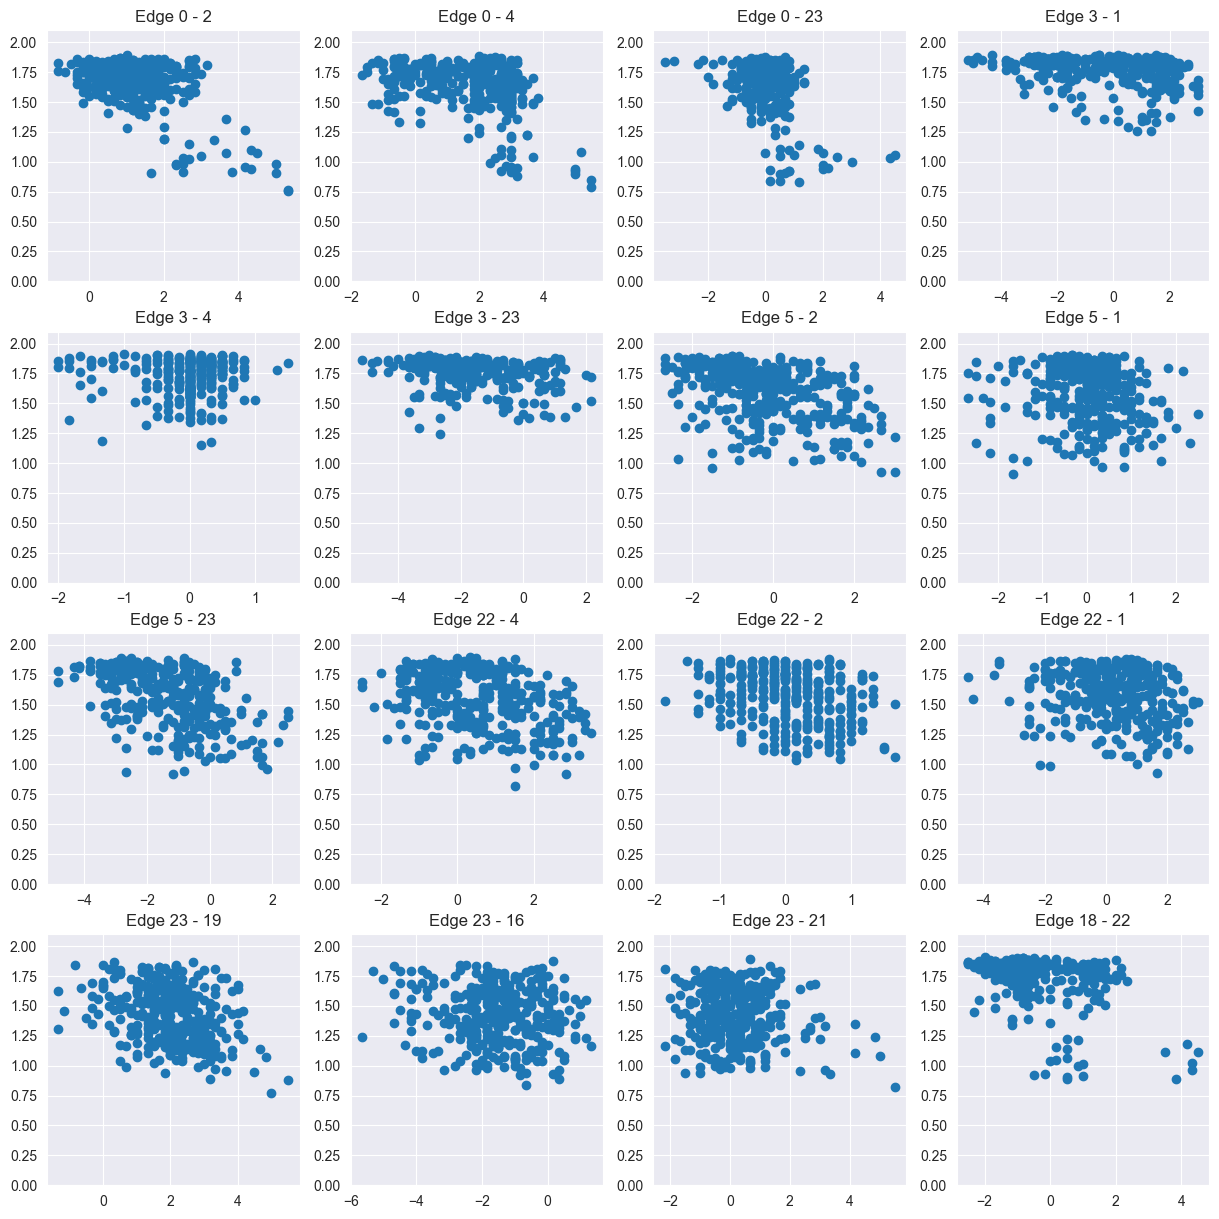

In [16]:
# plot different edge id, speed and diff, using subplots
import matplotlib.pyplot as plt
subplot_length = 4
fig, axs = plt.subplots(subplot_length, subplot_length, figsize=(15, 15))
time = np.arange(x_up.shape[1])
for i in range(subplot_length**2):
    edge_id = i
    diff = x_up[edge_id, :, :].numpy().mean(axis=-1).squeeze() - x_down[edge_id, :, :].numpy().mean(axis=-1).squeeze()
    axs[i//subplot_length, i%subplot_length].scatter(diff, pred_speed[edge_id, :].numpy().squeeze())
    axs[i//subplot_length, i%subplot_length].set_title(f"Edge {src[i]} - {dst[i]}")
    # x and y limits
    # axs[i//subplot_length, i%subplot_length].set_xlim(-5, 5)
    axs[i//subplot_length, i%subplot_length].set_ylim(0, 2.1)
    if i//subplot_length in [8, 9, 10, 11]:
        axs[i//subplot_length, i%subplot_length].set_xlabel('Diff')


## Fundamental diagram

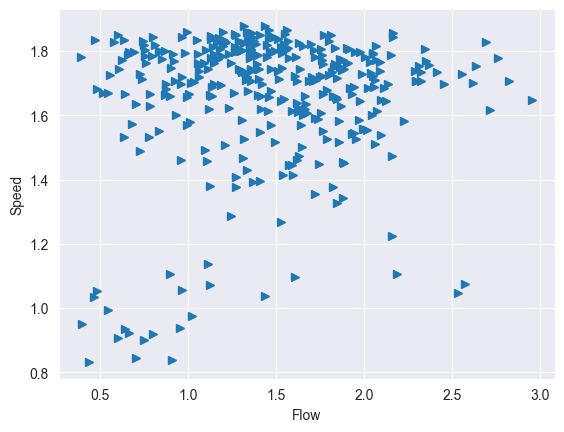

In [17]:
import matplotlib.pyplot as plt
# src_point = 17
# dst_point = 22
edge_id = np.where((src == src_idx) & (dst == dst_idx))[0]
# plt.plot(flow[edge_id, :250].squeeze(), speed[edge_id, :250].squeeze(), '*')
# plt.plot(flow[edge_id, 250:].squeeze(), speed[edge_id, 250:].squeeze(), '>')
plt.xlabel('Flow')
plt.ylabel('Speed')
plt.plot(pred_flow[edge_id, :].squeeze(), pred_speed[edge_id, :].squeeze(), '>')

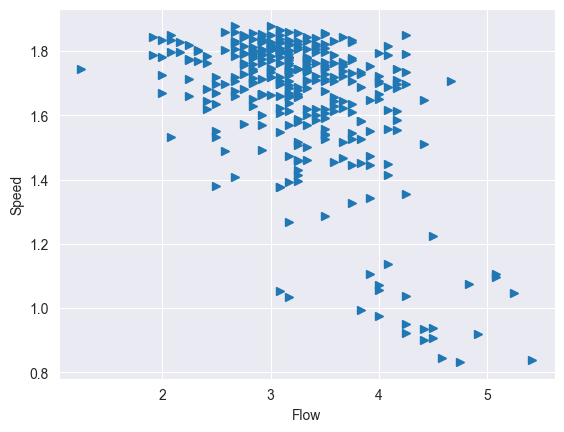

In [18]:
plt.xlabel('Flow')
plt.ylabel('Speed')
plt.plot(total_flow[edge_id, :].squeeze(), pred_speed[edge_id, :].squeeze(), '>')

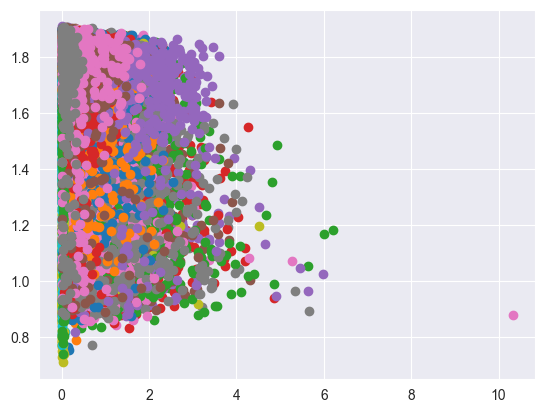

In [19]:
# use the predicted flow, for all edges
for i in range(pred_flow.shape[0]):
    # don't change
    plt.plot(pred_flow[i, :], pred_speed[i, :], 'o')

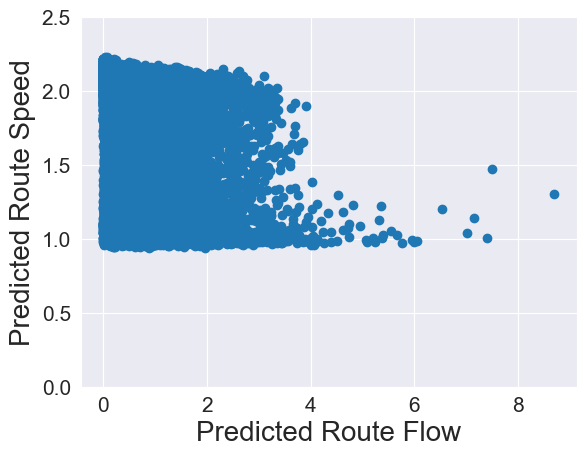

In [15]:
plt.scatter(pred_flow.reshape(-1,), pred_speed.reshape(-1,), marker='o')
plt.xlabel('Predicted Route Flow', fontsize=20)
plt.ylabel('Predicted Route Speed', fontsize=20)
plt.ylim(0, 2.5)
# plt.xlim(0, 20)
# x, y ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(f"./fig/{dataset_name}_pred_fd_{sc_name}.pdf", bbox_inches='tight')
plt.show()

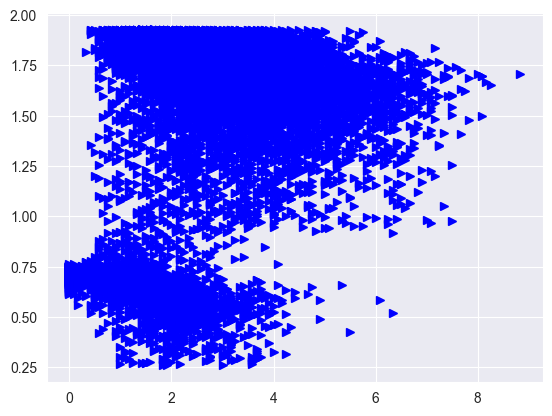

In [15]:
# use the total flow
for i in range(total_flow.shape[0]):
    plt.plot(total_flow[i, :], pred_speed[i, :], '>', color='b')

In [55]:
# ground truth FD
import pickle
with open("../nomad/examples/fd_data.pkl", "rb") as f:
    fd_all_scenarios = pickle.load(f)

In [139]:
sc

'sc_sensor/maze20'

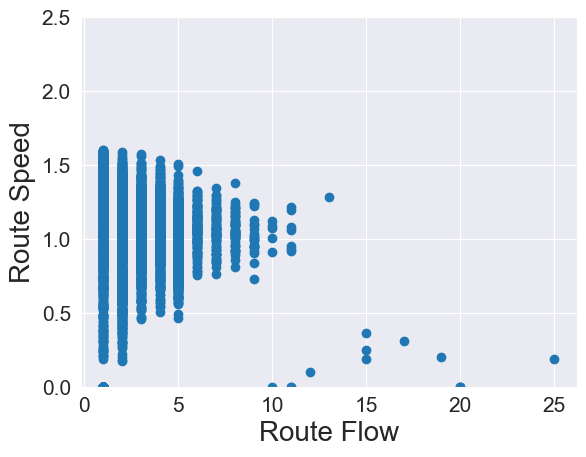

In [143]:
sc = "sc_sensor/maze14"
fd = fd_all_scenarios[sc]
OD_names = 'waypoint6|waypoint8'
# sub_df = fd[fd.index.get_level_values("OD")==OD_names]
sub_df = fd
flow = sub_df["f"].values
speed = sub_df["s"].values
plt.scatter(flow, speed, marker='o')
plt.xlabel('Route Flow', fontsize=20)
plt.ylabel('Route Speed', fontsize=20)
plt.ylim(0, 2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# save pdf
# plt.savefig(f"./fig/{dataset_name}_gt_fd.pdf", bbox_inches='tight')
plt.show()

In [15]:
with open("../nomad/examples/new_fd_data.pkl", "rb") as f:
    new_fd_all_scenarios = pickle.load(f)

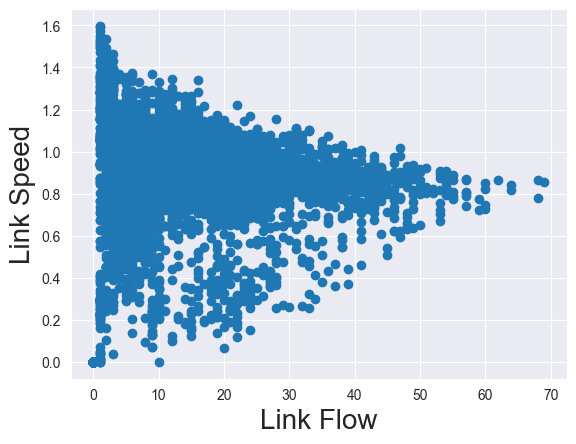

In [16]:
new_fd = new_fd_all_scenarios[sc]
speed = new_fd["speed"].reshape(-1,)
flow = new_fd["flow"].reshape(-1,)
plt.scatter(flow, speed, marker='o')
plt.xlabel('Link Flow', fontsize=20)
plt.ylabel('Link Speed', fontsize=20)
plt.show()

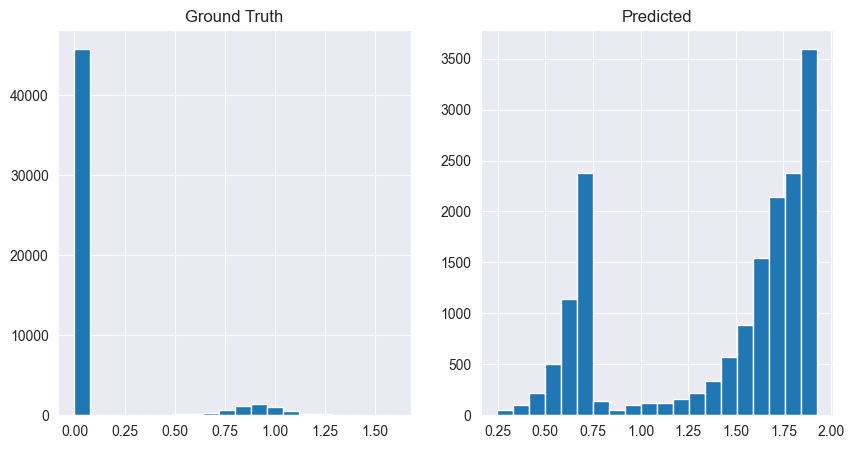

In [20]:
# distribution plot of the velocity
# plt.hist(speed[1, :], bins=20)
#subplot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(speed, bins=20)
axs[0].set_title("Ground Truth")
axs[1].hist(pred_speed.reshape(-1,), bins=20)
axs[1].set_title("Predicted")
plt.show()

In [17]:
point_to_node = {"waypoint8": [22, 23], "waypoint3": [4, 5], "waypoint6": [16, 17], "waypoint7": [11, 10],
                 "exit1": [21, 20], "exit2": [14, 15], "exit3": [12, 13], "exit4": [8, 9], "exit5": [6,7],
                 "exit6": [2,3], "exit7": [0,1], "exit8": [18,19]}
node_to_point = {22: "waypoint8", 23: "waypoint8", 4: "waypoint3", 5: "waypoint3", 16: "waypoint6", 17: "waypoint6",
                    11: "waypoint7", 10: "waypoint7", 21: "exit1", 20: "exit1", 14: "exit2", 15: "exit2", 12: "exit3",
                    13: "exit3", 8: "exit4", 9: "exit4", 6: "exit5", 7: "exit5", 2: "exit6", 3: "exit6", 0: "exit7",
                    1: "exit7", 18: "exit8", 19: "exit8"}   
act_list = ["waypoint8", "waypoint3", "waypoint6", "waypoint7", "exit1",
            "exit2", "exit3", "exit4", "exit5", "exit6", "exit7", "exit8"]
num_nodes = g.number_of_nodes()
src, dst = g.edges()
num_edges = len(src)

In [18]:
scenario_flow = new_fd_all_scenarios[sc]["flow"][:F.shape[1], :, :].transpose([1, 2, 0])
sample_size = F.shape[1]
F_mat = np.zeros((num_nodes, num_nodes, sample_size))
for i in range(num_edges):
    # F_mat[src[i], dst[i], :] = F[i, :]
      F_mat[src[i], dst[i], :] = pred_alpha[i, :].detach().numpy()
F_od_mat = np.zeros([len(point_to_node), len(point_to_node), sample_size])
for n in range(sample_size):
    for i in range(F_mat.shape[0]):
        if np.sum(F_mat[i, :]) == 0:
            continue
        for j in range(F_mat.shape[1]):
            src_node = node_to_point[i]  # waypoint
            dst_node = node_to_point[j]
            src_idx = act_list.index(src_node)
            dst_idx = act_list.index(dst_node)
            if F_mat[i, j, n] != 0:
                F_od_mat[src_idx, dst_idx, n] = F_mat[i, j, n]

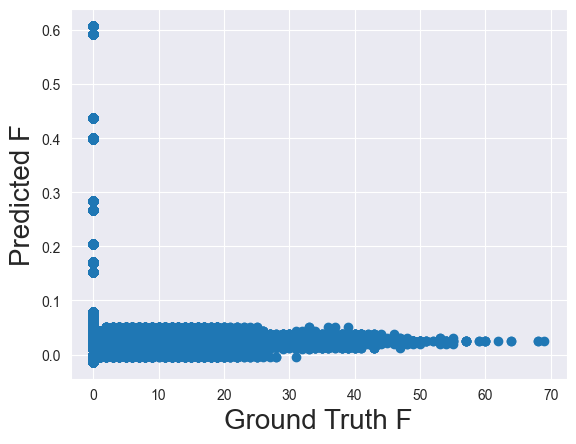

In [19]:
# plot the predicted F and the ground truth F
plt.scatter(scenario_flow.reshape(-1,), F_od_mat.reshape(-1,), marker='o')
plt.xlabel('Ground Truth F', fontsize=20)
plt.ylabel('Predicted F', fontsize=20)
plt.show()

In [52]:
with torch.no_grad():
    v_model = model.velocity_model
    up = v_model.linear12(v_model.relu(v_model.ln11(v_model.dropout(v_model.linear11(x_up)))))
    up = torch.sigmoid(up)

    down = v_model.linear22(v_model.relu(v_model.ln21(v_model.dropout(v_model.linear21(x_down)))))
    down = torch.sigmoid(down)

In [53]:
x_up.shape

torch.Size([48, 169, 6])

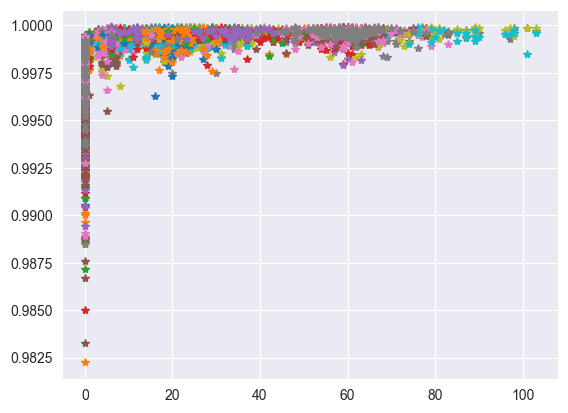

In [54]:
total_up_flow = torch.sum(x_up, dim=2).numpy()
up_flow_v = up.squeeze().numpy()
total_down_flow = torch.sum(x_down, dim=2).numpy()
down_flow_v = down.squeeze().numpy()
for i in range(total_up_flow.shape[0]):
    plt.plot(total_up_flow[i, :], up_flow_v[i, :], '*')

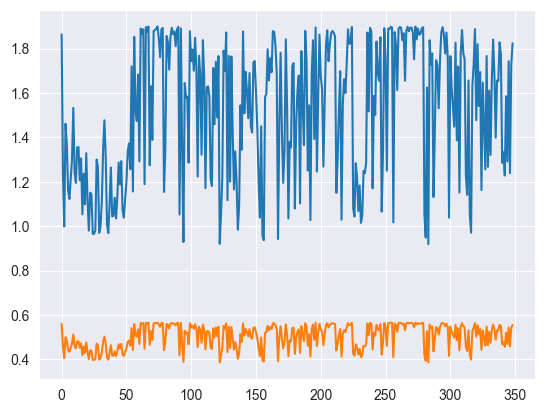

In [17]:
# speed and F
# import matplotlib.pyplot as plt
# time = np.arange(speed.shape[1])
# src_idx = 10
# dst_idx = 6
# edge_id = np.where((src == src_idx) & (dst == dst_idx))[0]
# plt.plot(time, speed[edge_id, :].squeeze())
# plt.plot(time, F[edge_id, :].squeeze())

## OD matrix

In [55]:
with torch.no_grad():
    num_edges = len(src)
    sample_size = x_test.shape[0]
    flow_mat = np.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        # alpha_mat[src[i], dst[i], :] = g.edata['alpha'][i, :]
        flow_mat[src[i], dst[i], :] = g.edata['message'][i, :]

In [56]:
node_to_point = {22: "waypoint8", 23: "waypoint8", 4: "waypoint3", 5: "waypoint3", 16: "waypoint6", 17: "waypoint6",
                    11: "waypoint7", 10: "waypoint7", 21: "exit1", 20: "exit1", 14: "exit2", 15: "exit2", 12: "exit3",
                    13: "exit3", 8: "exit4", 9: "exit4", 6: "exit5", 7: "exit5", 2: "exit6", 3: "exit6", 0: "exit7",
                    1: "exit7", 18: "exit8", 19: "exit8"}
point_to_node = {"waypoint8": [22, 23], "waypoint3": [4, 5], "waypoint6": [16, 17], "waypoint7": [11, 10],
                 "exit1": [21, 20], "exit2": [14, 15], "exit3": [12, 13], "exit4": [8, 9], "exit5": [6,7],
                 "exit6": [2,3], "exit7": [0,1], "exit8": [18,19]}

<Axes: >

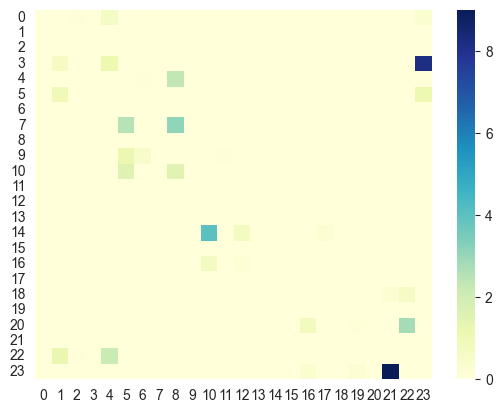

In [57]:
# visualize attention matrix
import seaborn as sns
sns.heatmap(flow_mat[..., -1], cmap="YlGnBu")

In [58]:
import pickle
# load the ground truth flow data
with open("../nomad/examples/branch_flow_data.pkl", "rb") as f:
    all_scenarios = pickle.load(f)

act_list = ["waypoint8", "waypoint3", "waypoint6", "waypoint7", "exit1",
            "exit2", "exit3", "exit4", "exit5", "exit6", "exit7", "exit8"]
# branch = "waypoint7|exit2"

gt_flow = all_scenarios["sc_sensor/maze0"]

In [59]:
gt_flow.shape

(180, 12, 12)

In [60]:
# generate the predicted od matrix
od_mat = np.zeros([len(point_to_node), len(point_to_node), flow_mat.shape[-1]])
# at_mat = flow_mat[..., -50:].numpy().sum(axis=-1)
# translate atten_mat to od_mat:
for n in range(flow_mat.shape[-1]):
    for i in range(flow_mat.shape[0]):
        if np.sum(flow_mat[i, :]) == 0:
            continue
        for j in range(flow_mat.shape[1]):
            src_node = node_to_point[i]  # waypoint
            dst_node = node_to_point[j]
            src_idx = act_list.index(src_node)
            dst_idx = act_list.index(dst_node)
            if flow_mat[i, j, n] != 0:
                od_mat[src_idx, dst_idx, n] = flow_mat[i, j, n]

In [61]:
od_mat.shape

(12, 12, 169)

<Figure size 2000x700 with 0 Axes>

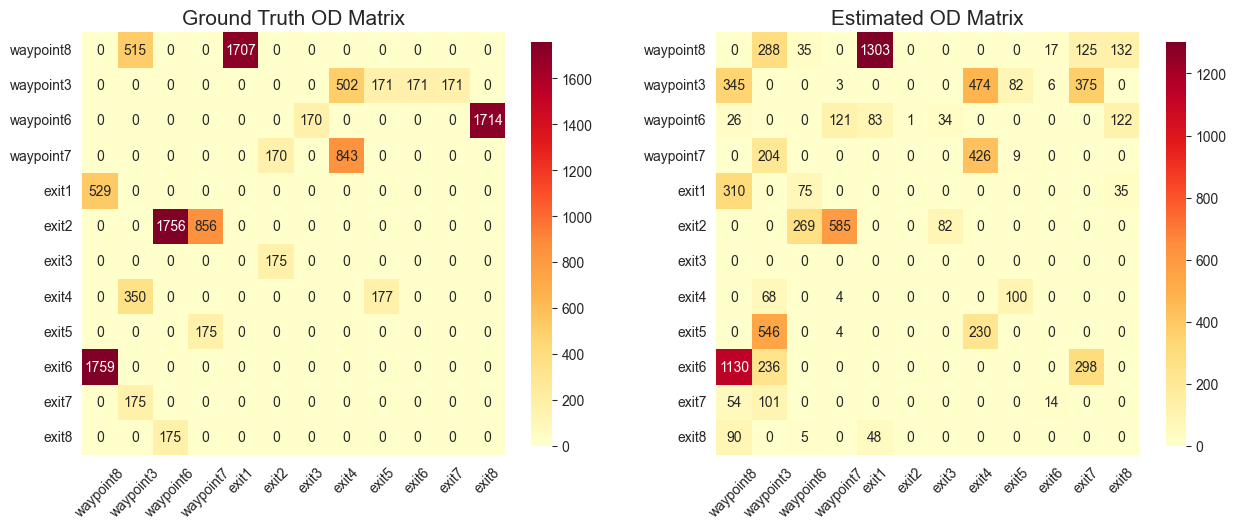

In [62]:
# visualize ground truth flow mat
# sns.heatmap(gt_flow.sum(axis=0), annot=True, fmt=".0f", xticklabels=act_list, yticklabels=act_list)
# plt.show()import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 7))
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ["white", "red"])
# Plot ground truth flow mat, sum over time in one scenario
sns.heatmap(gt_flow.sum(axis=0), annot=True, fmt=".0f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[0], square=True, cbar_kws={"shrink": 0.75}, cmap="YlOrRd")
axs[0].set_title('Ground Truth OD Matrix', fontsize=15)
axs[0].tick_params(axis='x', rotation=45)
# Plot predicted flow mat, use warm color
sns.heatmap(od_mat.sum(axis=-1), annot=True, fmt=".0f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[1], square=True, cbar_kws={"shrink": 0.75}, cmap="YlOrRd")
axs[1].set_title('Estimated OD Matrix', fontsize=15)
axs[1].tick_params(axis='x', rotation=45)

# Display the figure
plt.show()